# Trajectories by simple integration for advected waves and unadvected waves

In [2]:
import numpy as np
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

import xsimlab as xs

## Classes

In [3]:
@xs.process
class Position:
    """Compute the evolution of positions and velocities."""

    p_vars = xs.group("p_vars")
    p = xs.variable(dims="a", intent="inout", description="positions of particules", attrs={"units": "m"})
    
    def run_step(self):
        self._delta_p = sum((x for x in self.p_vars))
        
    def finalize_step(self):
        self.p += self._delta_p #p(t+dt)


In [4]:
def analytical_velocity_advected(t, x, um, uw, w, k):
    return um + uw*np.cos(w*t-k*(x-um*t))

def analytical_velocity_unadvected(t, x, um, uw, w, k):
    return (um + uw*np.cos(w*t-k*x))

@xs.process
class AnaVelocity:
    """Calculate velocity at t and in all positions.
    """
    
    # parameters
    um = xs.variable(description="uniform and constant flow amplitude", attrs={"units":"m/s"})
    uw = xs.variable(description="wave amplitude", attrs={"units":"m/s"})
    w = xs.variable(description="wave pulsation", attrs={"units":"s^-1"})
    k = xs.variable(description="wave number", attrs={"units":"m⁻1"})
    advected = xs.variable(description="advected wave", attrs={"units":"1"})#booléen
    
    # variables
    v = xs.variable(dims="a", intent="out", description="velocity of particules", attrs={"units": "m/s"})
    p = xs.foreign(Position, "p", intent="in")
    
    def velocity_func(self, *args):
        if self.advected:
            return analytical_velocity_advected(*args)
        else:
            return analytical_velocity_unadvected(*args)
        
    #INITIALISATION OF VELOCITY
    @xs.runtime(args="sim_start") #this way t is the beginning time of the simulation
    def initialize(self,t):
        self.v = self.velocity_func(t, self.p, self.um, self.uw, self.w, self.k)
    
    
    @xs.runtime(args=["step_start"])
    def run_step(self, t):
         self.v = self.velocity_func(t, self.p, self.um, self.uw, self.w, self.k)  # v(x(t),t)
        
        
    #CALCULATION OF VELOCITY AT t time and position p
    @xs.runtime(args=["step_end"])
    def finalize_step(self, t):
        self.v = self.velocity_func(t, self.p, self.um, self.uw, self.w, self.k)  # v(x(t+dt),t+dt)
        
    

In [5]:
@xs.process
class InitRegular:
    """Initialize `positions` profile with N regular values in a giving an interval."""

    mini = xs.variable(description="minimum for initial position", static=True)
    maxi = xs.variable(description="maximum for initial position", static=True)
    N = xs.variable(description="number of particules", static=True)
    
    a = xs.index(dims="a")

    p = xs.foreign(Position, "p", intent="out")
    
    def initialize(self):
        self.a = np.linspace(self.mini, self.maxi, self.N)
        self.p = self.a.copy()


In [6]:
@xs.process
class Euler:
    """Calculate positions at t+dt using Euler method.
"""
    p_advected = xs.variable(dims="a", intent="out", groups="p_vars")
    v = xs.foreign(AnaVelocity, "v", intent="in")

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        self.p_advected = self.v*dt #self.v est la vitesse à l'instant t 

In [7]:
@xs.process
class Runge_Kutta2:
    """Calculate positions at t+dt using Runge-Kutta method of order 2.
"""
    p_advected = xs.variable(dims="a", intent="out", groups="p_vars")

    v = xs.foreign(AnaVelocity, "v", intent="in")
    p = xs.foreign(Position, "p", intent="in")
    
    #parameters
    advected = xs.foreign(AnaVelocity, "advected", intent="in")
    um = xs.foreign(AnaVelocity, "um")
    uw = xs.foreign(AnaVelocity, "uw")
    w = xs.foreign(AnaVelocity, "w")
    k = xs.foreign(AnaVelocity, "k")
    
    def velocity_func(self, *args):
        if self.advected:
            return analytical_velocity_advected(*args)
        else:
            return analytical_velocity_unadvected(*args)
    
    @xs.runtime(args=["step_delta", "step_start"])
    def run_step(self, dt,t):
        self._p1 =self.p + self.v*dt
        self.p_advected = dt/2*(self.v + self.velocity_func(t, self._p1, self.um, self.uw, self.w, self.k))

In [8]:
@xs.process
class Runge_Kutta4:
    """Calculate positions at t+dt using Runge-Kutta method of order 4.
"""
    p_advected = xs.variable(dims="a", intent="out", groups="p_vars")

    v = xs.foreign(AnaVelocity, "v", intent="in")
    p = xs.foreign(Position, "p", intent="in")
    
    #parameters
    advected = xs.foreign(AnaVelocity, "advected", intent="in")
    um = xs.foreign(AnaVelocity, "um")
    uw = xs.foreign(AnaVelocity, "uw")
    w = xs.foreign(AnaVelocity, "w")
    k = xs.foreign(AnaVelocity, "k")

    def velocity_func(self, *args):
        if self.advected:
            return analytical_velocity_advected(*args)
        else:
            return analytical_velocity_unadvected(*args)
    
    @xs.runtime(args=["step_delta", "step_start"])
    def run_step(self, dt,t):
        
        t2=t+dt/2

        self._p1 = self.p + dt/2 * self.v
        self._v1 = self.velocity_func(t2, self._p1, self.um, self.uw, self.w, self.k)# v(p1, t+dt/2)
        
        self._p2 = self.p + dt/2 * self._v1 
        self._v2 = self.velocity_func(t2, self._p2, self.um, self.uw, self.w, self.k)# v(p2, t+dt/2)
        
        self._p3 = self.p + dt * self._v2
        self._v3 = self.velocity_func(t+dt, self._p3, self.um, self.uw, self.w, self.k)# v(p3, t+dt)
        
        
        self.p_advected = dt/6 *( self.v + 2*self._v2 + self._v3 + 2*self._v1)
        

In [9]:
# CREATE xs.Model
advect_model = xs.Model(
    {
        "position": Position,
        "init": InitRegular,
        "intmethod": Euler,
        "velocity": AnaVelocity
    }
)

In [10]:
advect_model.dependent_processes

{'position': ['init', 'intmethod'],
 'init': [],
 'intmethod': ['velocity'],
 'velocity': ['init']}

In [11]:
#CREATE SET UP
in_ds_advect = xs.create_setup(model=advect_model, 
                        clocks={'time': np.arange(0,86400*4, 3600/2),# hour by hour for four days
                                'otime': list(np.arange(0, 86400*4, 3600))}, 
                        master_clock='time',
                        input_vars={'init': {'mini': 0., 'maxi': 200e3, 'N':100},#INITIALISATION
                                    'velocity': {'um': .1, 'uw': 0.1, 'w':1.454441043*1e-4, 'k':6.2831*1e-5, 'advected':1},
                                    },
                        output_vars={'position__p' : 'otime','velocity__v' : 'otime'})

In [12]:
out_ds_advect = in_ds_advect.xsimlab.run(model=advect_model)
out_ds_advect

<xarray.Dataset>
Dimensions:             (a: 100, otime: 96, time: 192)
Coordinates:
  * a                   (a) float64 0.0 2.02e+03 4.04e+03 ... 1.98e+05 2e+05
  * otime               (otime) int64 0 3600 7200 10800 ... 334800 338400 342000
  * time                (time) float64 0.0 1.8e+03 ... 3.42e+05 3.438e+05
Data variables:
    init__N             int64 100
    init__maxi          float64 2e+05
    init__mini          float64 0.0
    position__p         (otime, a) float64 0.0 2.02e+03 ... 2.325e+05 2.346e+05
    velocity__advected  int64 1
    velocity__k         float64 6.283e-05
    velocity__um        float64 0.1
    velocity__uw        float64 0.1
    velocity__v         (otime, a) float64 0.2 0.1992 0.1968 ... 0.1913 0.1854
    velocity__w         float64 0.0001454

### Trajectories with Euler Method

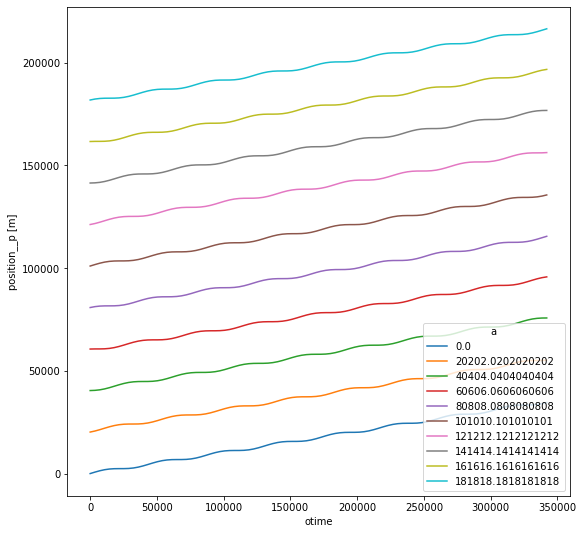

In [13]:
_p = out_ds_advect.position__p
_v = out_ds_advect.velocity__v
_p.isel(a=slice(0,None,10)).plot(x="otime", hue="a", figsize=(9,9));

In [14]:
_ds=out_ds_advect
v_a = analytical_velocity_advected(_ds.otime, _ds.position__p, _ds.velocity__um, _ds.velocity__uw, _ds.velocity__w, _ds.velocity__k)

In [15]:
(_ds.velocity__v - v_a)

<xarray.DataArray (otime: 96, a: 100)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * a        (a) float64 0.0 2.02e+03 4.04e+03 ... 1.96e+05 1.98e+05 2e+05
  * otime    (otime) int64 0 3600 7200 10800 ... 331200 334800 338400 342000

### Trajectories with Runge Kutta Method of order 2

In [16]:
runge2_advect_model = advect_model.update_processes({"intmethod": Runge_Kutta2})
runge2_ds_advect = in_ds_advect.xsimlab.run(model=runge2_advect_model)

_rds2 =runge2_ds_advect
_rp2 =_rds2.position__p
_rv2 =_rds2.velocity__v

rv2_a = analytical_velocity_advected(_rds2.otime, _rp2, _rds2.velocity__um, _rds2.velocity__uw, _rds2.velocity__w, _rds2.velocity__k)

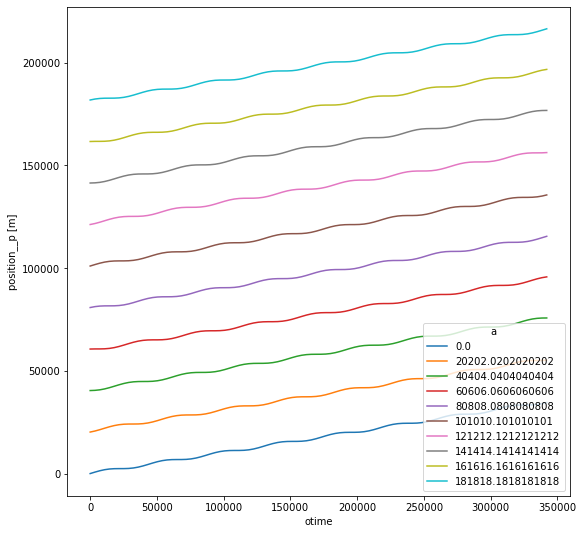

In [17]:
_rp2.isel(a=slice(0,None,10)).plot(x="otime", hue="a", figsize=(9,9));

In [18]:
(_rv2 - rv2_a)

<xarray.DataArray (otime: 96, a: 100)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * a        (a) float64 0.0 2.02e+03 4.04e+03 ... 1.96e+05 1.98e+05 2e+05
  * otime    (otime) int64 0 3600 7200 10800 ... 331200 334800 338400 342000

In [19]:
(_rp2-_p)

<xarray.DataArray 'position__p' (otime: 96, a: 100)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.45199999, -0.05223031, -0.55366738, ...,  1.38984583,
         0.93956495,  0.45267056],
       [ 2.55658061,  1.71388632,  0.80969553, ...,  3.9329901 ,
         3.30623424,  2.55765691],
       ...,
       [ 5.52913019,  5.74815187,  5.75890805, ...,  4.46093624,
         5.0972242 ,  5.52869263],
       [ 3.17391116,  3.63201003,  3.92282786, ...,  1.81541174,
         2.56071969,  3.17318775],
       [ 0.54801638,  0.9597416 ,  1.29289763, ..., -0.44655585,
         0.07257421,  0.54741665]])
Coordinates:
  * a        (a) float64 0.0 2.02e+03 4.04e+03 ... 1.96e+05 1.98e+05 2e+05
  * otime    (otime) int64 0 3600 7200 10800 ... 331200 334800 338400 342000

In [20]:
(_rv2-_v)

<xarray.DataArray 'velocity__v' (otime: 96, a: 100)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.36483449e-06, -1.19963019e-07, -8.52216304e-07, ...,
         5.99538833e-06,  3.47288904e-06,  1.36728600e-06],
       [ 1.35744589e-05,  8.28649569e-06,  3.46833949e-06, ...,
         2.35725829e-05,  1.88416743e-05,  1.35816626e-05],
       ...,
       [-3.47388991e-05, -3.57527411e-05, -3.48114748e-05, ...,
        -2.71053312e-05, -3.17763444e-05, -3.47362007e-05],
       [-1.73780529e-05, -2.11762689e-05, -2.38777785e-05, ...,
        -8.16822000e-06, -1.28757705e-05, -1.73723764e-05],
       [-1.79339969e-06, -3.77377936e-06, -5.85483228e-06, ...,
         8.07982722e-07, -1.85809741e-07, -1.79093125e-06]])
Coordinates:
  * a        (a) float64 0.0 2.02e+03 4.04e+03 ... 1.96e+05 1.98e+05 2e+05
  * otime    (otime) int64 0 3600 7200 10800 ... 331200 334800 338400 342000

### Trajectories with Runge Kutta Method of order 4

In [21]:
runge4_advect_model = advect_model.update_processes({"intmethod": Runge_Kutta4})
runge4_ds_advect = in_ds_advect.xsimlab.run(model=runge4_advect_model)

_rds4 =runge4_ds_advect
_rp4 =_rds4.position__p
_rv4 =_rds4.velocity__v

rv4_a = analytical_velocity_advected(_rds4.otime, _rp4, _rds4.velocity__um, _rds4.velocity__uw, _rds4.velocity__w, _rds4.velocity__k)

In [22]:
(_rv4 - rv4_a)

<xarray.DataArray (otime: 96, a: 100)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * a        (a) float64 0.0 2.02e+03 4.04e+03 ... 1.96e+05 1.98e+05 2e+05
  * otime    (otime) int64 0 3600 7200 10800 ... 331200 334800 338400 342000

In [23]:
_rp4-_rp2

<xarray.DataArray 'position__p' (otime: 96, a: 100)>
array([[   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [  -9.73768543,   -3.60207237,    2.56726687, ...,  -21.51475891,
         -15.74722853,   -9.7458649 ],
       [ -41.60288916,  -30.32215351,  -18.63089255, ...,  -62.15742523,
         -52.28862353,  -41.61768642],
       ...,
       [ -98.09241418, -109.59066633, -119.16294125, ...,  -70.28786721,
         -84.89008511,  -98.07576725],
       [ -48.77793836,  -59.10733413,  -68.41750446, ...,  -25.82785448,
         -37.60698787,  -48.76345358],
       [ -11.62921738,  -17.91489863,  -23.84556326, ...,    1.58692919,
          -5.08635206,  -11.62057715]])
Coordinates:
  * a        (a) float64 0.0 2.02e+03 4.04e+03 ... 1.96e+05 1.98e+05 2e+05
  * otime    (otime) int64 0 3600 7200 10800 ... 331200 334800 338400 342000

### Plots (exercices)

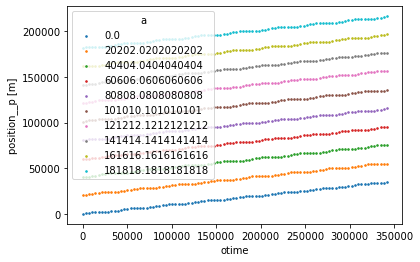

In [24]:
_ds.isel(a=slice(0,None,10)).plot.scatter(x="otime", y="position__p", hue="a",hue_style="discrete", marker='.', s=10)

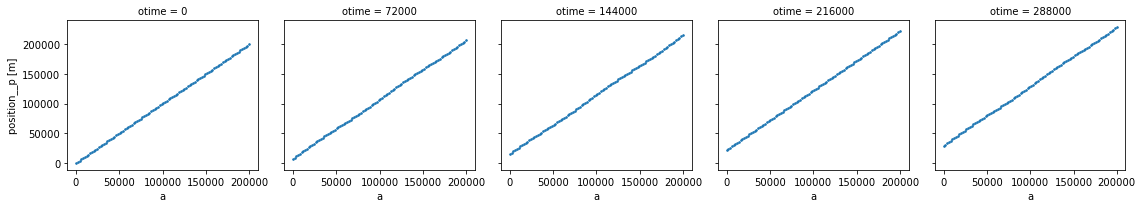

In [49]:
fg=_ds.isel(otime=slice(0,None,20)).plot.scatter(x="a", y="position__p", marker='.', s=10,col='otime')

In [60]:
fg.axes[0]

array([<AxesSubplot:title={'center':'otime = 0'}, xlabel='a', ylabel='position__p [m]'>,
       <AxesSubplot:title={'center':'otime = 0'}, xlabel='a', ylabel='position__p [m]'>,
       <AxesSubplot:title={'center':'otime = 0'}, xlabel='a', ylabel='position__p [m]'>,
       <AxesSubplot:title={'center':'otime = 0'}, xlabel='a', ylabel='position__p [m]'>,
       <AxesSubplot:title={'center':'otime = 0'}, xlabel='a', ylabel='position__p [m]'>],
      dtype=object)

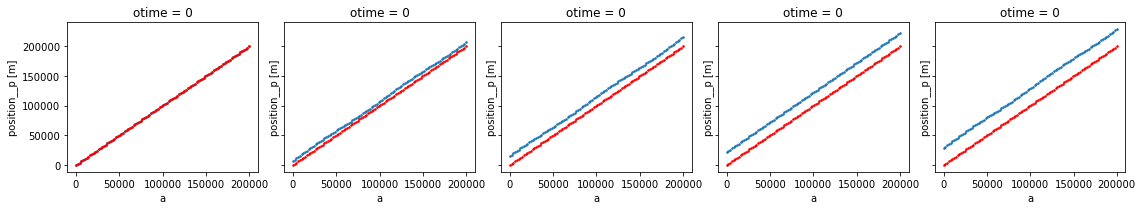

In [64]:
fg=_ds.isel(otime=slice(0,None,20)).plot.scatter(x="a", y="position__p", marker='.', s=10,col='otime')
for ax in fg.axes[0]:
    _ds.isel(otime=0).plot.scatter(x="a", y="position__p", marker='.', c='red', s=10, ax=ax)
